# Introduction

This notebook demonstrates how to refit a MEGNet formation energy model using PyTorch Lightning with MatGL.

In [ ]:
#pip install matplotlib pandas pytorch-lightning tqdm pymatgen dgl matgl

In [18]:
from __future__ import annotations

# 기본 Python 모듈 및 패키지 import
import os             # 운영 체제와 상호 작용하기 위한 모듈
import shutil         # 파일 및 디렉토리 작업을 위한 모듈
import warnings       # 경고를 관리하기 위한 모듈
import zipfile        # ZIP 아카이브를 처리하기 위한 모듈

import matplotlib.pyplot as plt     # 데이터 시각화를 위한 Matplotlib의 pyplot 모듈
import pandas as pd                 # 데이터 조작 및 분석을 위한 Pandas 라이브러리
import pytorch_lightning as pl      # PyTorch Lightning 라이브러리
import torch                        # PyTorch 딥러닝 프레임워크
from tqdm import tqdm               # 진행률 표시를 위한 라이브러리


# 외부 패키지 import
from dgl.data.utils import split_dataset            #  DGL(Distributed Graph Library) 패키지의 데이터 유틸리티 함수
from pymatgen.core import Structure                 #  pymatgen 라이브러리의 구조 클래스
from pytorch_lightning.loggers import CSVLogger     #  PyTorch Lightning의 CSV 로거 클래스


from matgl.ext.pymatgen import Structure2Graph, get_element_list     # matgl 라이브러리의 pymatgen 확장 모듈
from matgl.graph.data import MGLDataset, MGLDataLoader, collate_fn   # matgl 라이브러리의 그래프 데이터 관련 모듈
from matgl.layers import BondExpansion                               # matgl 라이브러리의 BondExpansion 클래스
from matgl.models import MEGNet                                      # matgl 라이브러리의 MEGNet 클래스
from matgl.utils.io import RemoteFile                                # matgl 라이브러리의 입출력 및 훈련 관련 유틸리티 모듈
from matgl.utils.training import ModelLightningModule                # matgl 라이브러리의 입출력 및 훈련 관련 유틸리티 모듈

# 경고를 무시하도록 설정하는 것으로, 출력을 더 깔끔하게 만듭니다.
warnings.simplefilter("ignore")

# Dataset Preparation

이제 MEGNet 형성 에너지 모델 훈련에 사용된 원본 데이터셋인 MP.2018.6.1을 figshare에서 다운로드하고 데이터를 캐시할 것입니다

In [19]:

import json

def load_dataset() -> tuple[list[Structure], list[str], list[float]]:
    """
    Load and process the dataset from a JSON file containing material properties.

    Returns:
        tuple[list[Structure], list[str], list[float]]: A tuple containing a list of structures, a list of material IDs, and a list of formation energies per atom.
    """
    # Assuming the dataset is named 'mpid_fE_structure_O.Si.json' and located in the current directory
    file_path = '/home/ljm/matgl_bandgap/demo/mpid_bg_structure_O_1.json'

    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} does not exist. Please make sure the dataset file is in the correct location.")

    # Load the dataset
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Initialize lists to store structures, material IDs, and formation energies
    structures = []
    mp_ids = []
    band_gaps = []

    # Iterate over the dataset
    for mp_id, (band_gap, structure_dict) in data.items():
        # Create a Structure object from the structure dictionary
        structure = Structure.from_dict(structure_dict)

        # Append to the lists
        structures.append(structure)
        mp_ids.append(mp_id)
        band_gaps.append(band_gap)

    return structures, mp_ids, band_gaps

# Load the dataset
structures, mp_ids, band_gaps = load_dataset()

For demonstration purposes, we are only going to select 100 structures from the entire set of structures to shorten the training time.

In [20]:
structures = structures
Band_g = band_gaps

Here, we set up the dataset.

In [21]:
# 데이터셋 내 원소 종류 추출
elem_list = get_element_list(structures)
# 그래프 변환기 설정
converter = Structure2Graph(element_types=elem_list, cutoff=5.0)
# convert the raw dataset into MEGNetDataset, 데이터셋 변환
mp_dataset = MGLDataset(
    structures=structures,
    labels={"Bgap": Band_g},
    converter=converter)

100%|██████████| 57826/57826 [01:38<00:00, 588.33it/s]


We will then split the dataset into training, validation and test data.

In [6]:
train_data, val_data, test_data = split_dataset(
    mp_dataset, # 모델에 입력으로 제공될 데이터셋
    frac_list=[0.8, 0.1, 0.1],

    shuffle=True,

    # 셔플링 시 사용되는 시드(seed) 값
    random_state=42,
)
train_loader, val_loader, test_loader = MGLDataLoader(
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    collate_fn=collate_fn,  # 데이터셋으로부터 미니배치를 생성하는 함수

    # 데이터로더에서 사용되는 미니배치의 크기를 나타내는 매개변수입니다.
    # 한 번에 처리되는 데이터 포인트의 수를 결정
    # 2개의 데이터 포인트를 동시에 처리하여 그래디언트를 계산하고 가중치를 업데이트
    batch_size=128,

    # 데이터로더에서 사용할 프로세스의 수를 나타내는 매개변수입니다.
    # 데이터를 로드하는 데 사용되는 병렬 처리의 정도를 결정

    num_workers=9,
)

# Model setup

In the next step, we setup the model and the ModelLightningModule. Here, we have initialized a MEGNet model from scratch. Alternatively, you can also load one of the pre-trained models for transfer learning, which may speed up the training.

In [22]:
# 노드 속성을 위한 임베딩 레이어를 설정
node_embed = torch.nn.Embedding(len(elem_list), 16)
# 본드 확장을 정의
bond_expansion = BondExpansion(rbf_type="Gaussian", initial=0.0, final=5.0, num_centers=100, width=0.5)

# MEGNet 모델의 아키텍처를 설정
model = MEGNet(
    dim_node_embedding=16,
    dim_edge_embedding=100,
    dim_state_embedding=2,#값 변동
    ntypes_stats = 4, #추가한 레이어 
    nblocks=3,
    hidden_layer_sizes_input=(64, 32),
    hidden_layer_sizes_conv=(64, 64, 32),
    hidden_layer_sizes_output=(32, 16),#위치 변경 레이어
    nlayers_set2set=1,
    niters_set2set=3,#값 변동
    activation_type="softplus2",
    is_classification=False,
    include_state= True,
    dropout= 0.3,#추가 
    graph_transformations= None, #추가 
    element_types= None,#추가 
    bond_expansion= None, #값변경 
    cutoff=5.0,#값 변경 
    gauss_width=0.5,
)
import torch.optim as optim
# setup the MEGNetTrainer
# lit_module = ModelLightningModule(model=model)

# Adam 옵티마이저 설정
adam_optimizer = optim.Adam(model.parameters(), lr=0.001)

# ModelLightningModule 초기화
lit_module = ModelLightningModule(model=model, optimizer=adam_optimizer, lr=0.001)

# Training



In [23]:
logger = CSVLogger("logs", name="MEGNet_training")
trainer = pl.Trainer(max_epochs=500, accelerator="gpu", logger=logger)
trainer.fit(model=lit_module, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/MEGNet_training
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type              | Params
--------------------------------------------
0 | model | MEGNet            | 189 K 
1 | mae   | MeanAbsoluteError | 0     
2 | rmse  | MeanSquaredError  | 0     
--------------------------------------------
189 K     Trainable params
100       Non-trainable params
189 K     Total params
0.758     Total estimated model params size (MB)


Epoch 499: 100%|██████████| 362/362 [01:00<00:00,  6.00it/s, v_num=0, val_Total_Loss=0.409, val_MAE=0.410, val_RMSE=0.632, train_Total_Loss=0.111, train_MAE=0.244, train_RMSE=0.330]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 362/362 [01:02<00:00,  5.76it/s, v_num=0, val_Total_Loss=0.409, val_MAE=0.410, val_RMSE=0.632, train_Total_Loss=0.111, train_MAE=0.244, train_RMSE=0.330]


# Visualizing the convergence

Finally, we can plot the convergence plot for the loss metrics. You can see that the MAE is already going down nicely with 20 epochs. Obviously, this is nowhere state of the art performance for the formation energies, but a longer training time should lead to results consistent with what was reported in the original MEGNet work.

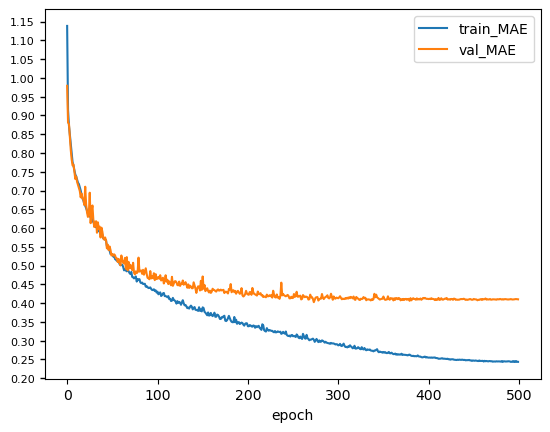

In [25]:
from matplotlib.ticker import MultipleLocator

metrics = pd.read_csv("/home/ljm/matgl_bandgap/demo/logs/MEGNet_training/version_0/metrics.csv")
metrics = metrics.set_index(metrics.columns[0])

# 시각화
metrics["train_MAE"].dropna().plot()
metrics["val_MAE"].dropna().plot()

plt.yticks(fontsize=8)  # 눈금 폰트 크기 설정
plt.gca().tick_params(axis='y', which='major', width=1)  # 주요 눈금 두께 설정
#plt.gca().tick_params(axis='y', which='minor', width=1)  # 보조 눈금 두께 설정

# 주요 눈금 간격 설정
majorLocator = MultipleLocator(0.05)  # 주요 눈금 간격을 1로 설정
plt.gca().yaxis.set_major_locator(majorLocator)

# 보조 눈금 간격 설정
#minorLocator = MultipleLocator(0.001)  # 보조 눈금 간격을 0.5로 설정
#plt.gca().yaxis.set_minor_locator(minorLocator)

_ = plt.legend()


In [31]:
print(mp_ids[10])
print("next")
print(band_gaps[10])
print("next")
print()
print("next")
print(structures[10])


mp-24555
next
0.9937000000000001
next

next
Full Formula (Mn4 Tl8 H8 O4 F20)
Reduced Formula: MnTl2H2OF5
abc   :   6.401460  12.851913   8.506299
angles:  89.999375  89.999846 103.176282
pbc   :       True       True       True
Sites (44)
  #  SP           a         b         c    magmom
---  ----  --------  --------  --------  --------
  0  Mn    5.8e-05   0.499932  0.5002      -3.823
  1  Mn    0.999839  0.999934  0.999795    -3.823
  2  Mn    0.000397  5.6e-05   0.499905     3.823
  3  Mn    6.3e-05   0.500066  0.000258     3.823
  4  Tl    0.889299  0.246136  0.750033     0
  5  Tl    0.889206  0.74602   0.749926    -0
  6  Tl    0.110524  0.253831  0.249938    -0
  7  Tl    0.110602  0.753947  0.250023    -0
  8  Tl    0.492671  0.445296  0.750044     0
  9  Tl    0.492586  0.945263  0.749902    -0
 10  Tl    0.507263  0.054689  0.2499      -0
 11  Tl    0.507342  0.554726  0.25006     -0
 12  H     0.368837  0.184916  0.843268    -0
 13  H     0.368914  0.685     0.843267     0
 

# Prediction & evalustion Code

In [26]:
torch.save(model.state_dict(), 'pre_Bg_2.pth')

In [27]:
model.load_state_dict(torch.load("/home/ljm/matgl_bandgap/demo/pre_Bg_2.pth"))

# 모델을 평가 모드로 설정합니다.
model.eval()

MEGNet(
  (bond_expansion): BondExpansion(
    (rbf): GaussianExpansion()
  )
  (embedding): EmbeddingBlock(
    (activation): SoftPlus2(
      (ssp): Softplus(beta=1, threshold=20)
    )
    (layer_node_embedding): Embedding(89, 16)
  )
  (edge_encoder): MLP(100 → 64, SoftPlus2, 64 → 32, SoftPlus2)
  (node_encoder): MLP(16 → 64, SoftPlus2, 64 → 32, SoftPlus2)
  (state_encoder): MLP(2 → 64, SoftPlus2, 64 → 32, SoftPlus2)
  (blocks): ModuleList(
    (0): MEGNetBlock(
      (activation): SoftPlus2(
        (ssp): Softplus(beta=1, threshold=20)
      )
      (edge_func): Identity()
      (node_func): Identity()
      (state_func): Identity()
      (conv): MEGNetGraphConv(
        (edge_func): MLP(128 → 64, SoftPlus2, 64 → 64, SoftPlus2, 64 → 32, SoftPlus2)
        (node_func): MLP(96 → 64, SoftPlus2, 64 → 64, SoftPlus2, 64 → 32, SoftPlus2)
        (state_func): MLP(96 → 64, SoftPlus2, 64 → 64, SoftPlus2, 64 → 32, SoftPlus2)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    

In [28]:
from __future__ import annotations

import warnings

import torch
from pymatgen.core import Lattice, Structure

import matgl

# To suppress warnings for clearer output
warnings.simplefilter("ignore")

In [29]:
struct = Structure.from_spacegroup("P2_13", Lattice.cubic(5.96), ["C", "O"], [[0.959164,	0.959164,	0.959164], [0.069818,	0.069818,	0.069818]])

In [30]:
band_G = model.predict_structure(struct)
print(f"The predicted Band gap for CO is {float(band_G):.3f} eV.")

The predicted Band gap for CO is 5.870 eV.


# 초기화 코드 

다만 오류가 안나는 것을 방지하기 위해 돌리는 것을 추천

In [17]:
# This code just performs cleanup for this notebook.
'''
for fn in ("dgl_graph.bin", "lattice.pt", "dgl_line_graph.bin", "state_attr.pt", "labels.json"):
    try:
        os.remove(fn)
    except FileNotFoundError:
        pass

shutil.rmtree("logs")
'''

SyntaxError: incomplete input (3773133023.py, line 2)